Best parameters found: {'max_depth': 10, 'min_samples_split': 50, 'n_estimators': 100}
Precision Score: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.70      0.54        40
           1       0.67      0.40      0.50        60

    accuracy                           0.52       100
   macro avg       0.55      0.55      0.52       100
weighted avg       0.57      0.52      0.52       100

Backtest Precision Score: 0.5347043701799485
Backtest Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.78      0.57      2472
           1       0.53      0.21      0.30      3037

    accuracy                           0.46      5509
   macro avg       0.49      0.49      0.43      5509
weighted avg       0.49      0.46      0.42      5509



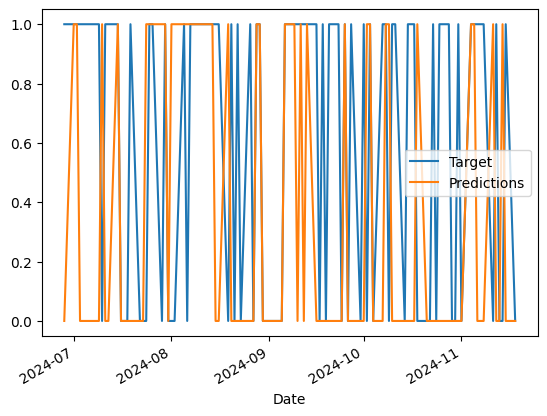

In [4]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, classification_report
from sklearn.model_selection import GridSearchCV

# Load S&P 500 data
sp500 = yf.Ticker("SPY") #^GSPC and AAPL and SPY
sp500 = sp500.history(period="max")
sp500 = sp500.loc["1990-01-01":].copy()

# Clean up columns and add target variable
del sp500["Dividends"]
del sp500["Stock Splits"]
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

# Add EMA feature with a window size (e.g., 50 days)
sp500["EMA_50"] = sp500["Close"].ewm(span=50, adjust=False).mean()

# Add the EMA_50 to the predictors list
predictors = ["Close", "Volume", "Open", "High", "Low", "EMA_50"]

# Split data into train and test sets
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_split': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

# Instantiate RandomForestClassifier
model = RandomForestClassifier(random_state=1)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, scoring='precision', cv=5)
grid_search.fit(train[predictors], train["Target"])

# Display best parameters from grid search
print("Best parameters found:", grid_search.best_params_)

# Re-train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(train[predictors], train["Target"])

# Evaluate model performance on the test set
preds = best_model.predict(test[predictors])
print("Precision Score:", precision_score(test["Target"], preds))
print("Classification Report:\n", classification_report(test["Target"], preds))

# Plot combined predictions and target for visualization
combined = pd.concat([test["Target"], pd.Series(preds, index=test.index, name="Predictions")], axis=1)
combined.plot()

# Define backtesting function with updated EMA_50 predictor
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:, 1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

# Backtest function
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i + step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

# Run backtest and evaluate precision
predictions = backtest(sp500,  best_model, predictors)
print("Backtest Precision Score:", precision_score(predictions["Target"], predictions["Predictions"]))
print("Backtest Classification Report:\n", classification_report(predictions["Target"], predictions["Predictions"]))